# Simple Neuron
One simple neuron of linear neuran network can be described as a simple function $f(x) = w \cdot x + b$. Where paramaters $w$ and $b$ are usually learned parameters through the testing phase.

The function of neuron is also called forward step or forward propagation.

In [2]:

class Neuron:
    def __init__(self, weight, bias, lr=0.01):
        self.weight = weight
        self.bias = bias
        self.lr = lr

    def forward(self, input):
        return input * self.weight + self.bias




Now in order to get bot $w$ and $b$ we need to create our training function and a loss function. One of the most basic loss function is so called mean squared error $L = (\hat{y} - y)^2$ where $y$ is our desired result and $\hat{y}$ is our current result which is $\hat{y} = w \cdot x + b$

We need to now design a gradient via derivating the loss function by $b$ and $w$.

$
\frac{\partial L}{\partial w}
= \frac{\partial}{\partial w} (\hat{y} - y)^2 = 2(\hat{y} - y)\frac{\partial \hat{y}}{\partial w} = 2(\hat{y} - y)x
$

$
\frac{\partial L}{\partial b}
= \frac{\partial}{\partial b} (\hat{y} - y)^2 = 2(\hat{y} - y)\frac{\partial \hat{y}}{\partial b} = 2(\hat{y} - y)
$

Now down we write our training function and we can see the use of learning rate, it is a control for how fast does neuron learn.

In [12]:
import random

def train(neuron: Neuron, x, y):
    # forward pass
    y_hat = neuron.forward(x)

    # loss gradient
    error = y_hat - y

    # gradients
    d_w = 2 * error * x
    d_b = 2 * error

    # update
    neuron.weight -= neuron.lr * d_w
    neuron.bias -= neuron.lr * d_b

neuron = Neuron(weight=1, bias=1, lr=0.001)

# learn y = 2x + 1
for _ in range(1, 10000):
    x = random.uniform(-10, 10)
    y = 2 * x + 1
    train(neuron, x=x, y=y)

print(neuron.weight, neuron.bias, neuron.forward(2))

1.9999999999998512 0.9999999999883584 4.999999999988061


Now neuron of this type is from linear neural network and usually looks this way $f(x) = w_1 \cdot x_1 + w_2 \cdot x_2 + w_3 \cdot x_3 + ... + w_n \cdot x_n + b$. It takes multiple inputs and has multiple weights. It could be thus written in the following format $f(x) = \vec{w}^{\mathsf{T}} \cdot \vec{x} + b$ where $\vec{x}$ is input vector and $\vec{w}$ is a vector containing the weights.

In [13]:
import numpy as np

class LinearNeuron:
    def __init__(self, n_inputs, lr=0.01, weight_scale=0.1, seed=None):
        rng = np.random.default_rng(seed)
        self.w = rng.uniform(-weight_scale, weight_scale, size=(n_inputs,))  # shape: (n,)
        self.b = 0.0
        self.lr = lr

    def forward(self, x):
        x = np.asarray(x, dtype=np.float64)          # shape: (n,)
        return self.w @ x + self.b                   # scalar

    def train_step(self, x, y):
        x = np.asarray(x, dtype=np.float64)          # (n,)
        y = float(y)

        y_hat = self.forward(x)
        error = y_hat - y                            # scalar

        # Using L = 1/2 (y_hat - y)^2
        # dL/dw = error * x
        # dL/db = error
        self.w -= self.lr * (error * x)
        self.b -= self.lr * error

        return 0.5 * error * error


rng = np.random.default_rng(0)

neuron = LinearNeuron(n_inputs=2, lr=0.05, seed=1)

for step in range(20000):
    x = rng.uniform(-1, 1, size=(2,))
    y = 3*x[0] - 2*x[1] + 1
    loss = neuron.train_step(x, y)

print("w:", neuron.w)
print("b:", neuron.b)
print("test x=[0.2,-0.4] -> pred:", neuron.forward([0.2, -0.4]), "true:", 3*0.2 - 2*(-0.4) + 1)


w: [ 3. -2.]
b: 1.0
test x=[0.2,-0.4] -> pred: 2.4000000000000004 true: 2.4000000000000004


# Neural layer
Neurons, as we can learn from nature, appear in layers and through many trials we have found layering neurons to be the best design. One linear neural layer can be described as: $f(\vec{x}) = \mathbf{W} \cdot \vec{x} + \vec{b}$. Where \mathbf{W} are weights of all the neurons in the layer. Each row represents weight of one neuron. Similar to \vec{b} each element is one bias element of one neuron.

In [14]:
import numpy as np

class LinearLayer:
    def __init__(self, in_features, out_features, lr=0.01, weight_scale=0.1, seed=None):
        rng = np.random.default_rng(seed)
        self.W = rng.uniform(
            -weight_scale, weight_scale, size=(out_features, in_features)
        )
        self.b = np.zeros(out_features)
        self.lr = lr

    def forward(self, x):
        """
        x: shape (in_features,)
        returns: shape (out_features,)
        """
        x = np.asarray(x, dtype=np.float64)
        self.x = x  # cache for backward
        return self.W @ x + self.b

    def train_step(self, x, y):
        """
        y: target, shape (out_features,)
        Loss: L = 1/2 ||y_hat - y||^2
        """
        y = np.asarray(y, dtype=np.float64)

        y_hat = self.forward(x)
        error = y_hat - y                      # (out_features,)

        # gradients
        dW = np.outer(error, self.x)           # (out_features, in_features)
        db = error                             # (out_features,)

        # update
        self.W -= self.lr * dW
        self.b -= self.lr * db

        return 0.5 * np.sum(error**2)

rng = np.random.default_rng(0)

layer = LinearLayer(in_features=2, out_features=3, lr=0.05, seed=1)

A = np.array([
    [2.0, -1.0],
    [0.5,  3.0],
    [-2.0, 0.25]
])
c = np.array([1.0, -2.0, 0.5])

def target(x):
    return A @ x + c

for _ in range(20000):
    x = rng.uniform(-1, 1, size=(2,))
    y = target(x)
    layer.train_step(x, y)

x_test = np.array([0.2, -0.4])
print("pred:", layer.forward(x_test))
print("true:", target(x_test))


pred: [ 1.80000000e+00 -3.10000000e+00  1.66533454e-16]
true: [ 1.8 -3.1  0. ]


We now need to update our linear layer so it has a backward function for a backpropagation.

In [7]:
import numpy as np

class LinearLayer:
    def __init__(self, in_features, out_features, lr=0.01, weight_scale=0.1, seed=None):
        rng = np.random.default_rng(seed)
        self.W = rng.uniform(-weight_scale, weight_scale, size=(out_features, in_features))
        self.b = np.zeros(out_features)
        self.lr = lr
        self.x = None

    def forward(self, x):
        x = np.asarray(x, dtype=np.float64)
        self.x = x
        return self.W @ x + self.b

    def backward(self, dout):
        """
        dout: dL/dy, shape (out_features,)
        returns: dL/dx, shape (in_features,)
        """
        dout = np.asarray(dout, dtype=np.float64)

        dW = np.outer(dout, self.x)     # (out, in)
        db = dout                       # (out,)
        dx = self.W.T @ dout            # (in,)

        # SGD update
        self.W -= self.lr * dW
        self.b -= self.lr * db

        return dx


# Neural Network

In [5]:
class MLP:
    def __init__(self, in_features, hidden, out_features, lr=0.01, seed=None):
        self.l1 = LinearLayer(in_features, hidden, lr=lr, seed=seed)
        self.l2 = LinearLayer(hidden, out_features, lr=lr, seed=None if seed is None else seed + 1)

    def forward(self, x):
        z1 = self.l1.forward(x)
        y_hat = self.l2.forward(z1)
        return y_hat

    def train_step(self, x, y):
        y = np.asarray(y, dtype=np.float64)

        # forward
        y_hat = self.forward(x)

        # loss: 1/2 ||y_hat - y||^2
        error = y_hat - y
        loss = 0.5 * np.sum(error**2)

        # backward (chain rule)
        dout = error                 # dL/dy_hat for 1/2 squared error
        dout = self.l2.backward(dout)
        dout = self.act.backward(dout)
        _    = self.l1.backward(dout)

        return loss


## Dataset
neural network cannot work without a dataset, we shall use MNIST dataset, sample of the dataset can be seen bellow.
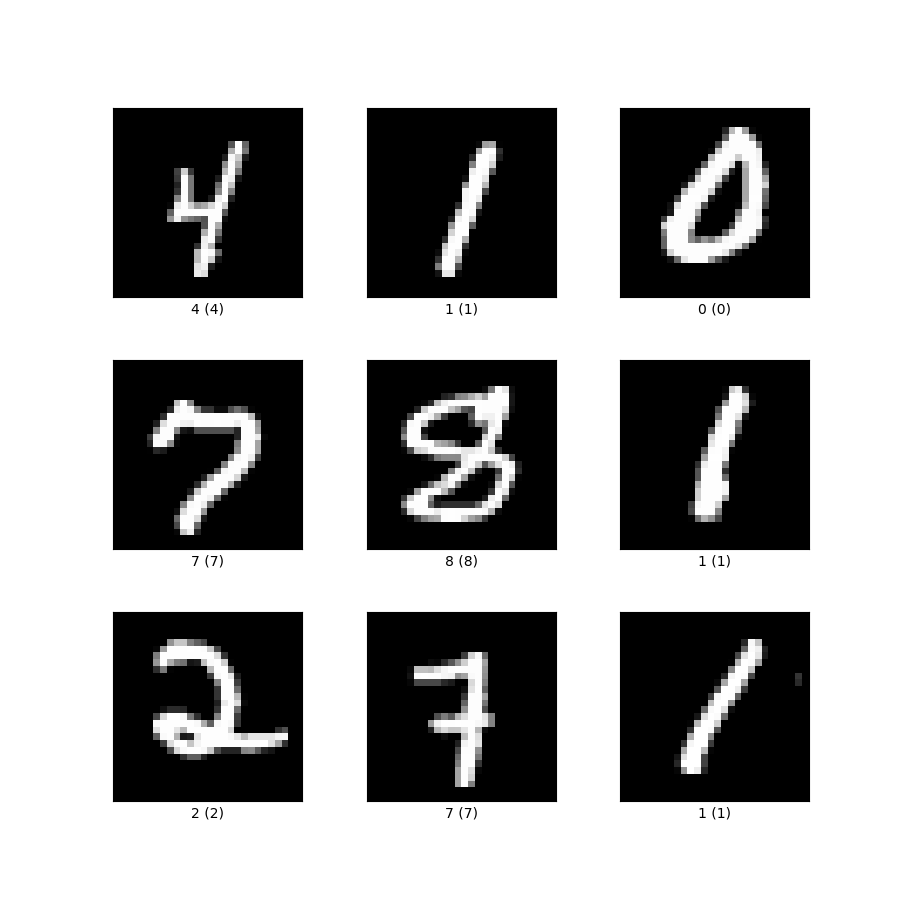


### Download
We have to download the dataset and then train, lets start with download. __You can skip this step__ the dataset is already in the repo.

In [1]:
from sklearn.datasets import fetch_openml
import numpy as np
import os

print("Downloading MNIST...")
X, y = fetch_openml(
    "mnist_784",
    version=1,
    return_X_y=True,
    as_frame=False
)

# Convert types
X = X.astype(np.float32) / 255.0   # normalize to [0,1]
y = y.astype(np.int64)

print("Downloaded:")
print("X shape:", X.shape)  # (70000, 784)
print("y shape:", y.shape)  # (70000,)

os.makedirs("data", exist_ok=True)

save_path = "data/mnist.npz"
np.savez_compressed(save_path, X=X, y=y)

print(f"Saved dataset to {save_path}")

Downloaded:
X shape: (70000, 784)
y shape: (70000,)
Saved dataset to data/mnist.npz


### Opening Dataset
After downloading the dataset we can open it.

In [2]:
save_path = "data/mnist.npz"
data = np.load(save_path)
X_loaded = data["X"]
y_loaded = data["y"]

print("Loaded from disk:")
print("X_loaded shape:", X_loaded.shape)
print("y_loaded shape:", y_loaded.shape)

Loaded from disk:
X_loaded shape: (70000, 784)
y_loaded shape: (70000,)


and we can display it.

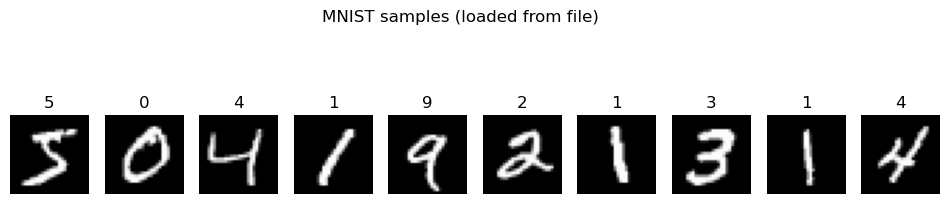

In [3]:
import matplotlib.pyplot as plt
n_show = 10
plt.figure(figsize=(12, 3))

for i in range(n_show):
    plt.subplot(1, n_show, i + 1)
    plt.imshow(X_loaded[i].reshape(28, 28), cmap="gray")
    plt.title(str(y_loaded[i]))
    plt.axis("off")

plt.suptitle("MNIST samples (loaded from file)")
plt.show()

## Training a Neural Net
Finaly lets write down our neural network and train it on a sample from the dataset, aka training data.

In [9]:
import numpy as np

class LinearLayer:
    def __init__(self, in_features, out_features, lr=0.01, weight_scale=0.1, seed=None):
        rng = np.random.default_rng(seed)
        self.W = rng.uniform(-weight_scale, weight_scale, size=(out_features, in_features))
        self.b = np.zeros(out_features)
        self.lr = lr
        self.x = None

    def forward(self, x):
        x = np.asarray(x, dtype=np.float64)
        self.x = x
        return self.W @ x + self.b

    def backward(self, dout):
        dout = np.asarray(dout, dtype=np.float64)

        dW = np.outer(dout, self.x)     # (out, in)
        db = dout                       # (out,)
        dx = self.W.T @ dout            # (in,)

        self.W -= self.lr * dW
        self.b -= self.lr * db
        return dx


class Identity:
    def forward(self, x):
        return x
    def backward(self, dout):
        return dout


class MLP:
    def __init__(self, in_features, hidden, out_features, lr=0.01, seed=None):
        self.l1 = LinearLayer(in_features, hidden, lr=lr, seed=seed)
        self.l2 = LinearLayer(hidden, out_features, lr=lr, seed=None if seed is None else seed + 1)
        self.act = Identity()  # does nothing (still linear overall)

    def forward(self, x):
        z1 = self.l1.forward(x)
        z1 = self.act.forward(z1)
        y_hat = self.l2.forward(z1)
        return y_hat

    def train_step(self, x, y):
        y = np.asarray(y, dtype=np.float64)

        y_hat = self.forward(x)

        error = y_hat - y
        loss = 0.5 * np.sum(error**2)

        dout = error
        dout = self.l2.backward(dout)
        dout = self.act.backward(dout)
        _    = self.l1.backward(dout)

        return loss


# ---- load saved MNIST ----
data = np.load("data/mnist.npz")
X = data["X"].astype(np.float64)   # (70000, 784), assumed normalized [0,1]
y = data["y"].astype(np.int64)     # (70000,)

X_train, y_train = X[:60000], y[:60000]
X_test,  y_test  = X[60000:], y[60000:]

# ---- train ----
model = MLP(in_features=784, hidden=128, out_features=10, lr=0.01, seed=1)

rng = np.random.default_rng(0)
epochs = 3

for epoch in range(epochs):
    idx = rng.permutation(len(X_train))
    total_loss = 0.0

    for k, i in enumerate(idx, start=1):
        x_i = X_train[i]

        # inline one-hot target (required because your loss is vector MSE)
        y_vec = np.zeros(10, dtype=np.float64)
        y_vec[y_train[i]] = 1.0

        total_loss += model.train_step(x_i, y_vec)

        if k % 10000 == 0:
            print(f"epoch {epoch+1} step {k} avg_loss {total_loss / k:.4f}")

# ---- quick sanity print (no accuracy computation) ----
logits = model.forward(X_test[0])
print("example logits:", logits)
print("pred:", int(np.argmax(logits)), "true:", int(y_test[0]))


epoch 1 step 10000 avg_loss 0.2581
epoch 1 step 20000 avg_loss 0.2428
epoch 1 step 30000 avg_loss 0.2358
epoch 1 step 40000 avg_loss 0.2324
epoch 1 step 50000 avg_loss 0.2297
epoch 1 step 60000 avg_loss 0.2276
epoch 2 step 10000 avg_loss 0.2155
epoch 2 step 20000 avg_loss 0.2161
epoch 2 step 30000 avg_loss 0.2151
epoch 2 step 40000 avg_loss 0.2150
epoch 2 step 50000 avg_loss 0.2143
epoch 2 step 60000 avg_loss 0.2137
epoch 3 step 10000 avg_loss 0.2132
epoch 3 step 20000 avg_loss 0.2140
epoch 3 step 30000 avg_loss 0.2118
epoch 3 step 40000 avg_loss 0.2121
epoch 3 step 50000 avg_loss 0.2115
epoch 3 step 60000 avg_loss 0.2113
example logits: [-0.01372239 -0.01806498  0.10729296  0.03349599 -0.18440403  0.03584938
  0.03533807  1.00878732 -0.0111375   0.00656366]
pred: 7 true: 7


Here we can test the results.

example logits: [-0.09918358  0.16659535 -0.39650262  0.64008017 -0.24495405  0.28044135
  0.13641636  0.39021397  0.11797772  0.00891544]
pred: 3 true: 3


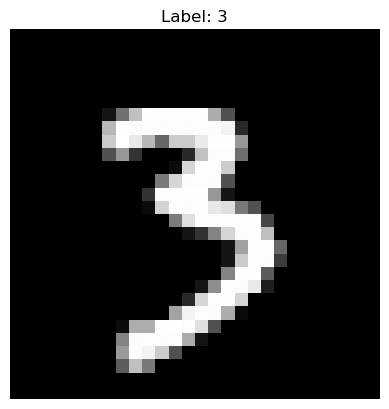

In [16]:
import matplotlib.pyplot as plt
i = 30
logits = model.forward(X_test[i])
print("example logits:", logits)
print("pred:", int(np.argmax(logits)), "true:", int(y_test[i]))

plt.imshow(X_test[i].reshape(28, 28), cmap="gray")
plt.title(f"Label: {y_test[i]}")
plt.axis("off")
plt.show()